In [496]:
# Importing base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import scipy.stats as st

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from imblearn.combine import SMOTEENN
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

# Importing configparser for managing files and settings
import configparser as cp

# Importing warnings and turning off deprecation warnings to clear the field of view a bit.
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

# Define Questions: #
* Which Genre has the best rating, on average?
* Does the price influence the user ratings? What about the reviews?
* Which Year has received the best ratings?
* What factors make a best seller?

In [159]:
# Establishing a config file and extracting the relevant information within

config = cp.ConfigParser()
config.read("config.ini")
BOOKS = config.get("links", "BOOKS")
KINDLE = config.get("links", "KINDLE")

In [160]:
books_df = pd.read_csv(BOOKS)
kindle_df = pd.read_csv(KINDLE)

**Data Cleaning and Exploration:**

In [162]:
books_df.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17,2009,Non Fiction
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5,2009,Non Fiction
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13,2009,Fiction
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14,2009,Non Fiction
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4,2009,Fiction


In [163]:
kindle_df.head()

,asin,title,author,soldBy,imgUrl,productURL,stars,reviews,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name
0,B00TZE87S4,Adult Children of Emotionally Immature Parents...,Lindsay C. Gibson,Amazon.com Services LLC,https://m.media-amazon.com/images/I/713KZTsaYp...,https://www.amazon.com/dp/B00TZE87S4,4.8,0,9.99,False,6,True,False,False,2015-06-01 00:00:00.000,Parenting & Relationships
1,B08WCKY8MB,"From Strength to Strength: Finding Success, Ha...",Arthur C. Brooks,Penguin Group (USA) LLC,https://m.media-amazon.com/images/I/A1LZcJFs9E...,https://www.amazon.com/dp/B08WCKY8MB,4.4,0,16.99,False,6,False,False,False,2022-02-15 00:00:00.000,Parenting & Relationships
2,B09KPS84CJ,Good Inside: A Guide to Becoming the Parent Yo...,Becky Kennedy,HarperCollins Publishers,https://m.media-amazon.com/images/I/71RIWM0sv6...,https://www.amazon.com/dp/B09KPS84CJ,4.8,0,16.99,False,6,False,True,False,2022-09-13 00:00:00.000,Parenting & Relationships
3,B07S7QPG6J,Everything I Know About Love: A Memoir,Dolly Alderton,HarperCollins Publishers,https://m.media-amazon.com/images/I/71QdQpTiKZ...,https://www.amazon.com/dp/B07S7QPG6J,4.2,0,9.95,True,6,False,True,False,2020-02-25 00:00:00.000,Parenting & Relationships
4,B00N6PEQV0,The Seven Principles for Making Marriage Work:...,John Gottman,Random House LLC,https://m.media-amazon.com/images/I/813o4WOs+w...,https://www.amazon.com/dp/B00N6PEQV0,4.7,0,13.99,False,6,False,False,False,2015-05-05 00:00:00.000,Parenting & Relationships


In [164]:
cleaned_kindle_df = kindle_df.drop(["asin", "soldBy", "imgUrl", "productURL", "isKindleUnlimited", "category_id", "isBestSeller",
                                   "isEditorsPick", "isGoodReadsChoice"], axis=1)

In [165]:
cleaned_kindle_df.head(1)

,title,author,stars,reviews,price,publishedDate,category_name
0,Adult Children of Emotionally Immature Parents...,Lindsay C. Gibson,4.8,0,9.99,2015-06-01 00:00:00.000,Parenting & Relationships


In [166]:
cleaned_kindle_df["category_name"].value_counts()

category_name
Mystery, Thriller & Suspense    6272
Engineering & Transportation    6162
Science & Math                  5955
Parenting & Relationships       5901
Children's eBooks               5747
Teen & Young Adult              5738
Foreign Language                5724
Travel                          5526
LGBTQ+ eBooks                   5517
Computers & Technology          5504
Crafts, Hobbies & Home          5502
Biographies & Memoirs           5405
Cookbooks, Food & Wine          5333
Law                             5027
Education & Teaching            4986
Religion & Spirituality         4970
Arts & Photo graphy             4916
Politics & Social Sciences      4207
Literature & Fiction            4152
Humor & Entertainment           4095
Science Fiction & Fantasy       3995
Self-Help                       3493
Reference                       3388
Sports & Outdoors               3206
Medical                         2583
Business & Money                2577
Romance                 

In [167]:
books_df["Genre"].value_counts()

Genre
Non Fiction    388
Fiction        312
Name: count, dtype: int64

In [168]:
# Conforming dataframes

books_df["Genre"] = books_df["Genre"].apply(lambda x: "Unknown" if x == "Fiction" else "Nonfiction")
cleaned_kindle_df.columns = books_df.columns

In [169]:
all_data_df = pd.concat([books_df, cleaned_kindle_df])
all_data_df

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17.00,2009,Nonfiction
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5.00,2009,Nonfiction
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13.00,2009,Unknown
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14.00,2009,Nonfiction
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4.00,2009,Unknown
...,...,...,...,...,...,...,...
133097,Anna Karenina,Leo Tolstoy,4.7,0,0.00,2023-09-15 00:00:00.000,Nonfiction
133098,Scary Smart: Scary Smart: The Future of Artifi...,Mo Gawdat,4.4,0,9.99,2021-09-30 00:00:00.000,Nonfiction
133099,The Count of Monte Cristo: The Original Unabri...,Alexandre Dumas,4.8,0,1.99,2023-09-15 00:00:00.000,Nonfiction
133100,War And Peace,Leo Tolstoy,4.7,0,0.00,2023-08-25 00:00:00.000,Nonfiction


In [170]:
date_formats = ["%Y-%m-%d %H:%M:%S.%f", "%Y"]

# Adapted function to parse dates.
# Credits to Co-User

def parsing_data(input):
    for fmt in date_formats:
        try:
            return pd.to_datetime(input, format=fmt)
        except ValueError:
            continue
    return pd.NaT
    

In [171]:
all_data_df["Date"] = all_data_df["Year"].apply(parsing_data)
all_data_df.drop(["Year"], axis=1, inplace=True)
all_data_df

,Name,Author,User Rating,Reviews,Price,Genre,Date
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17.00,Nonfiction,2009-01-01
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5.00,Nonfiction,2009-01-01
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13.00,Unknown,2009-01-01
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14.00,Nonfiction,2009-01-01
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4.00,Unknown,2009-01-01
...,...,...,...,...,...,...,...
133097,Anna Karenina,Leo Tolstoy,4.7,0,0.00,Nonfiction,2023-09-15
133098,Scary Smart: Scary Smart: The Future of Artifi...,Mo Gawdat,4.4,0,9.99,Nonfiction,2021-09-30
133099,The Count of Monte Cristo: The Original Unabri...,Alexandre Dumas,4.8,0,1.99,Nonfiction,2023-09-15
133100,War And Peace,Leo Tolstoy,4.7,0,0.00,Nonfiction,2023-08-25


# Exploring the data

In [173]:
all_data_df.duplicated().sum()

2

In [174]:
all_data_df.drop_duplicates(inplace=True)

In [175]:
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133800 entries, 0 to 133101
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Name         133800 non-null  object        
 1   Author       133375 non-null  object        
 2   User Rating  133800 non-null  float64       
 3   Reviews      133800 non-null  int64         
 4   Price        133800 non-null  float64       
 5   Genre        133800 non-null  object        
 6   Date         84781 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 8.2+ MB


In [176]:
all_data_df.isna().sum()

Name               0
Author           425
User Rating        0
Reviews            0
Price              0
Genre              0
Date           49019
dtype: int64

In [177]:
all_data_df.reset_index(drop=True)

,Name,Author,User Rating,Reviews,Price,Genre,Date
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17.00,Nonfiction,2009-01-01
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5.00,Nonfiction,2009-01-01
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13.00,Unknown,2009-01-01
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14.00,Nonfiction,2009-01-01
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4.00,Unknown,2009-01-01
...,...,...,...,...,...,...,...
133795,Anna Karenina,Leo Tolstoy,4.7,0,0.00,Nonfiction,2023-09-15
133796,Scary Smart: Scary Smart: The Future of Artifi...,Mo Gawdat,4.4,0,9.99,Nonfiction,2021-09-30
133797,The Count of Monte Cristo: The Original Unabri...,Alexandre Dumas,4.8,0,1.99,Nonfiction,2023-09-15
133798,War And Peace,Leo Tolstoy,4.7,0,0.00,Nonfiction,2023-08-25


**Which genre has the best Rating, on average?**

In [179]:
ratings_df = all_data_df[["Genre", "User Rating"]]

In [180]:
sorted_ratings = ratings_df.groupby("Genre").mean().sort_values(by="User Rating", ascending=False).reset_index()

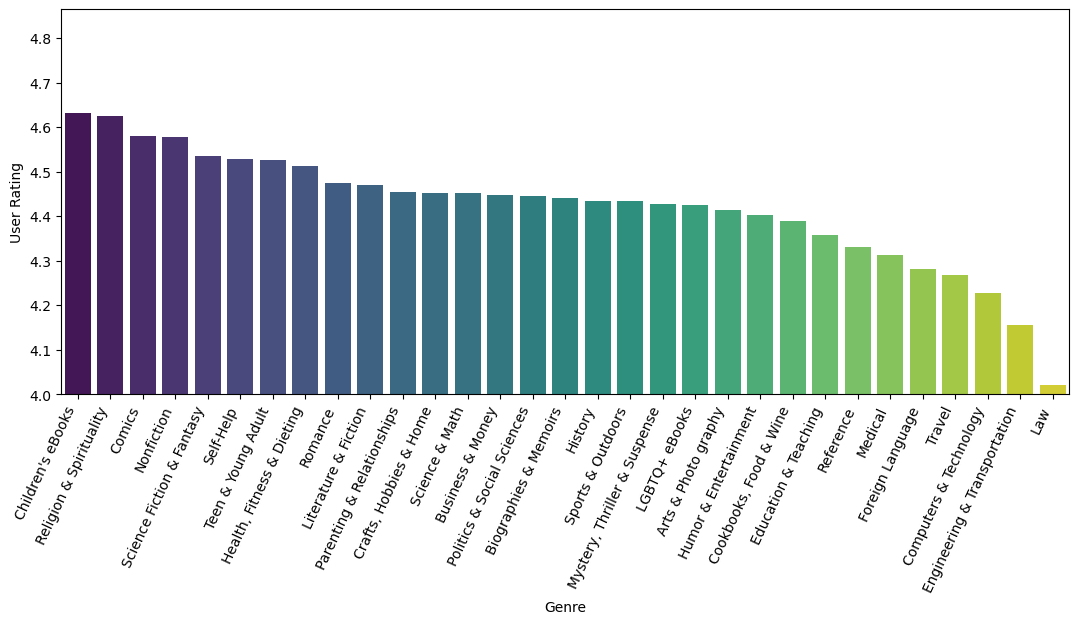

In [181]:
# All Genres sorted by Rating, excluding unknowns

plt.figure(figsize=(13, 5))
ax = sns.barplot(sorted_ratings[sorted_ratings["Genre"]!="Unknown"], x="Genre", y="User Rating", hue="Genre", palette="viridis")
ax.set_ylim(4)
plt.xticks(rotation=65, ha="right")
plt.show()

**Does the price influence the rating?**

In [183]:
bins = [0, 10, 40, 80, 100, 800]
all_data_df["Tag"] = pd.cut(all_data_df["Price"], bins = bins, labels=["cheap","average","high","expensive","overprized"],
                            include_lowest=True) 

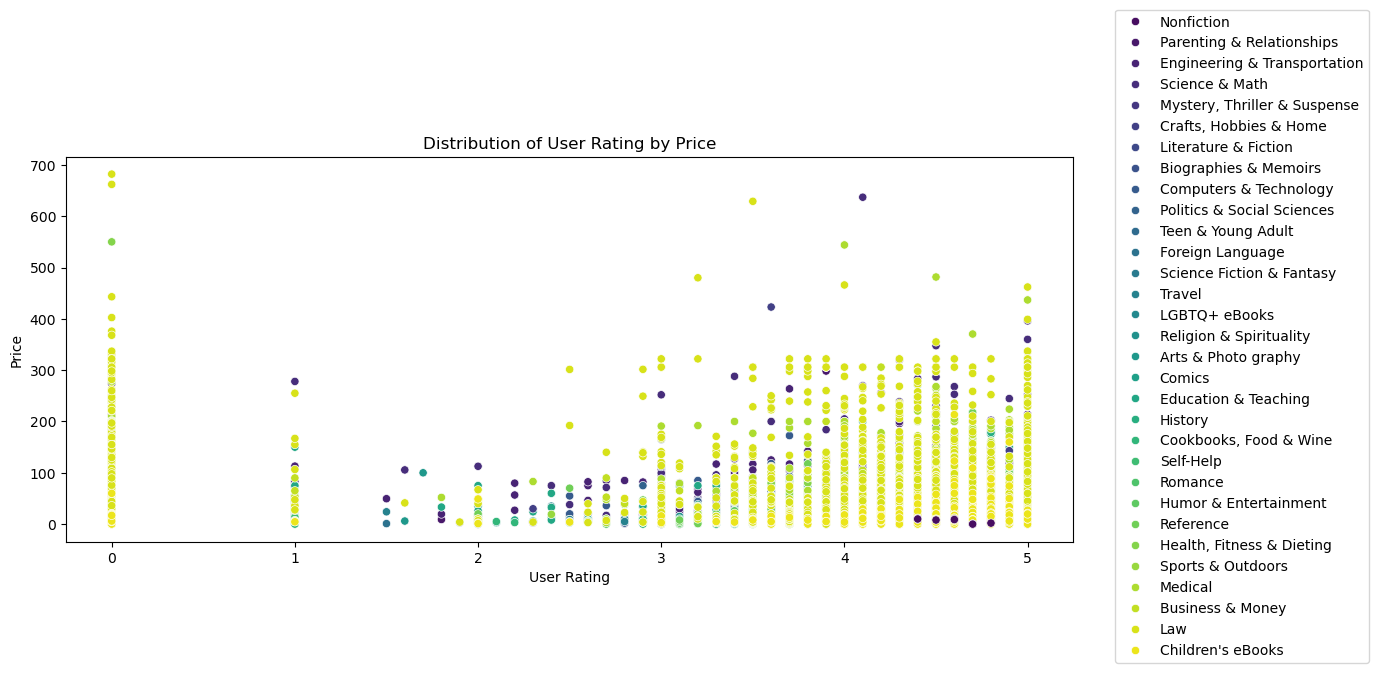

In [184]:
# Plotting a scatterplot to find patterns

plt.figure(figsize=(13, 5))
ax = sns.scatterplot(all_data_df[all_data_df["Genre"]!="Unknown"], x="User Rating", y="Price", hue="Genre", palette="viridis")
plt.title("Distribution of User Rating by Price")
plt.legend(bbox_to_anchor=(1.3,1.4), loc="upper right")

Text(0.5, 1.0, 'Distribution of Reviews by Price')

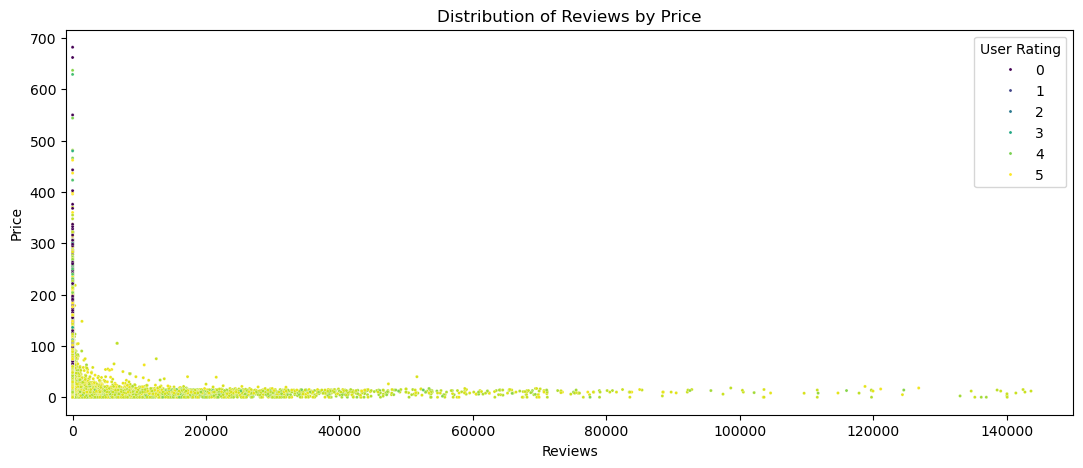

In [185]:
# Plotting the amount of reviews against the price
# Excluding outliers with reviews > 150000

plt.figure(figsize=(13, 5))
ax = sns.scatterplot(all_data_df[all_data_df["Genre"]!="Unknown"], x="Reviews", y="Price", hue="User Rating", palette="viridis", s=5)
ax.set_xlim(-1000,150000)
plt.title("Distribution of Reviews by Price")

**Which year has on average the best rating?**

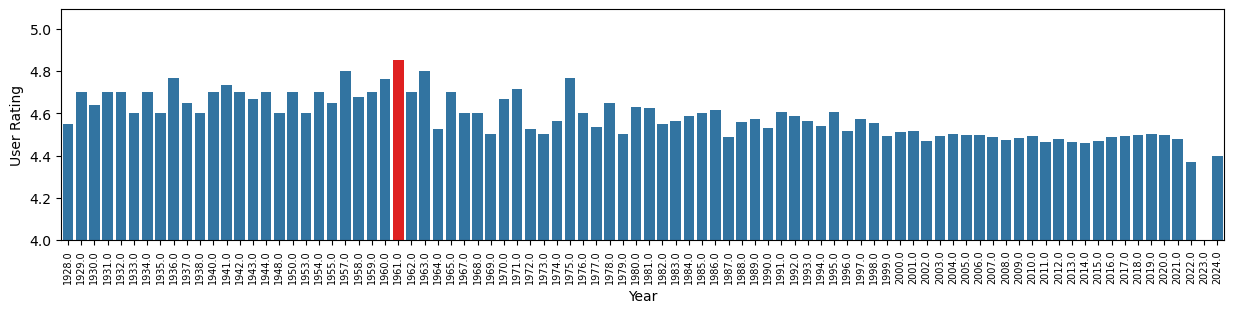

In [187]:
# Extracting each year with its average rating and plotting them.

all_data_df["Year"] = all_data_df["Date"].dt.year
years_df = all_data_df[["Year", "User Rating"]].groupby("Year").mean().sort_values(by="Year", ascending=False).reset_index(
    drop=False)
max_year = years_df.sort_values(by="User Rating", ascending=False).head(1)

plt.figure(figsize=(15,3))
ax = sns.barplot(years_df, x="Year", y="User Rating")
ax2 = sns.barplot(max_year, x=years_df["Year"], y="User Rating", color="red")
ax.set_ylim(4)
plt.xticks(rotation=90, size=7)
plt.show()

**What makes a bestseller?**

In [189]:
# Exploring the kindle dataset

bestseller_df = all_data_df.merge(kindle_df[["title", "isBestSeller"]], left_on="Name", right_on="title").drop(["title", "Tag"], axis=1)
bestseller_df.head()

,Name,Author,User Rating,Reviews,Price,Genre,Date,Year,isBestSeller
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17.00,Nonfiction,2009-01-01,2009.0,False
1,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.5,8493,12.99,Self-Help,2009-10-06,2009.0,False
2,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14.00,Nonfiction,2009-01-01,2009.0,False
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14.00,Nonfiction,2010-01-01,2010.0,False
4,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14.00,Nonfiction,2011-01-01,2011.0,False


In [190]:
# The dataframe is imbalanced, desiring equilibrium

bestseller_df["isBestSeller"].value_counts()

isBestSeller
False    133733
True       2351
Name: count, dtype: int64

# Preparing the dataframe for processing via machine learning

In [192]:
enc = LabelEncoder()
bestseller_df["Genre"] = enc.fit_transform(bestseller_df["Genre"])
bestseller_df["isBestSeller"] = bestseller_df["isBestSeller"].replace({False:0, True:1})

In [193]:
bestseller_df

,Name,Author,User Rating,Reviews,Price,Genre,Date,Year,isBestSeller
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17.00,19,2009-01-01,2009.0,0
1,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.5,8493,12.99,27,2009-10-06,2009.0,0
2,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14.00,19,2009-01-01,2009.0,0
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14.00,19,2010-01-01,2010.0,0
4,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14.00,19,2011-01-01,2011.0,0
...,...,...,...,...,...,...,...,...,...
136079,The Dream: The Extraordinary Revelation Of Who...,David Icke,4.5,0,7.99,19,2023-09-01,2023.0,0
136080,THE EYES OF DARKNESS,Dean Koontz,4.4,0,9.99,19,2022-03-05,2022.0,0
136081,Anna Karenina,Leo Tolstoy,4.7,0,0.00,19,2023-09-15,2023.0,1
136082,Scary Smart: Scary Smart: The Future of Artifi...,Mo Gawdat,4.4,0,9.99,19,2021-09-30,2021.0,0


In [194]:
features = bestseller_df.drop(["Name", "Author", "isBestSeller", "Date", "Year"], axis=1)
target = bestseller_df["isBestSeller"]

In [267]:
# Due to a significant imbalance we are going to undersample the features and oversample the target using SMOTEENN

sme = SMOTEENN(sampling_strategy = .3, random_state = 42)
features_sme, target_sme = sme.fit_resample(features, target)

In [268]:
target_sme.value_counts()

isBestSeller
0    112413
1     22637
Name: count, dtype: int64

In [239]:
# Due to confusing and seemingly deprecated documentation: 

help(SMOTEENN)

Help on class SMOTEENN in module imblearn.combine._smote_enn:

class SMOTEENN(imblearn.base.BaseSampler)
 |  SMOTEENN(*, sampling_strategy='auto', random_state=None, smote=None, enn=None, n_jobs=None)
 |  
 |  Over-sampling using SMOTE and cleaning using ENN.
 |  
 |  Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.
 |  
 |  Read more in the :ref:`User Guide <combine>`.
 |  
 |  Parameters
 |  ----------
 |  sampling_strategy : float, str, dict or callable, default='auto'
 |      Sampling information to resample the data set.
 |  
 |      - When ``float``, it corresponds to the desired ratio of the number of
 |        samples in the minority class over the number of samples in the
 |        majority class after resampling. Therefore, the ratio is expressed as
 |        :math:`\alpha_{os} = N_{rm} / N_{M}` where :math:`N_{rm}` is the
 |        number of samples in the minority class after resampling and
 |        :math:`N_{M}` is the number of samples in the m

In [277]:
X_train, X_test, y_train, y_test = train_test_split(features_sme, target_sme, test_size=0.35, random_state=42)

In [279]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [357]:
help(LogisticRegression())

Help on LogisticRegression in module sklearn.linear_model._logistic object:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', '

In [474]:
logreg = LogisticRegression()
params = {"random_state":[42],
          "solver":["sag", "saga"],
          "max_iter":[0,100,2000,100],
         }

In [484]:
model = GridSearchCV(logreg, params, scoring="accuracy", refit=True)

In [486]:
model.fit(X_train_scaled, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'max_iter': [0, 100, 2000, 100], 'random_state': [42],
                         'solver': ['sag', 'saga']},
             scoring='accuracy')

In [492]:
print(model.best_params_)
print(model.best_score_)

{'max_iter': 0, 'random_state': 42, 'solver': 'sag'}
0.8314460825984196


In [502]:
y_pred = model.predict(X_test)

C:\Users\PariahJack\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [506]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mse, r2)

0.1658838960819159 -0.19887386816141217
